In [55]:
import geopandas as gpd
import numpy as np

import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [52]:
gdf = gpd.read_file("../data/raw/traffic_counts_final")
gdf

,fid,intn_id,traffic_co,geometry
0,1.0,0.0,2605.0,POINT (419953.000 563814.000)
1,2.0,1.0,2605.0,POINT (420030.000 563786.000)
2,3.0,2.0,1661.0,POINT (424305.000 563825.000)
3,4.0,3.0,3807.0,POINT (424086.000 563463.000)
4,5.0,4.0,3103.0,POINT (424257.000 563483.000)
...,...,...,...,...
147,148.0,943539.0,50.0,POINT (423252.998 564921.169)
148,149.0,943543.0,36.0,POINT (422363.998 569299.169)
149,150.0,943545.0,13.0,POINT (429211.998 564690.170)
150,151.0,943547.0,112.0,POINT (421262.998 569249.169)


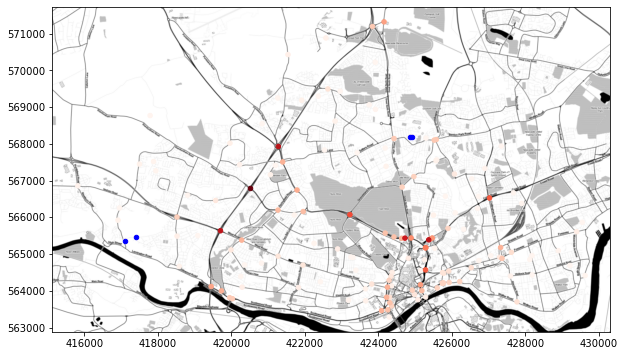

In [118]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
gdf["sqrt_traffic"] = np.sqrt(gdf["traffic_co"])
gdf.sort_values(by="sqrt_traffic").plot(
    ax=ax,
    column="traffic_co",
    markersize=20,
    cmap="Reds"
)

gdf[gdf["intn_id"] == 943499.0].plot(color="b", markersize=20, ax=ax)
gdf[gdf["intn_id"] == 943550.0].plot(color="b", markersize=20, ax=ax)

ctx.add_basemap(
    ax,
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=gdf.crs.to_epsg()
)



(415128.65009042964, 430316.3480730198)

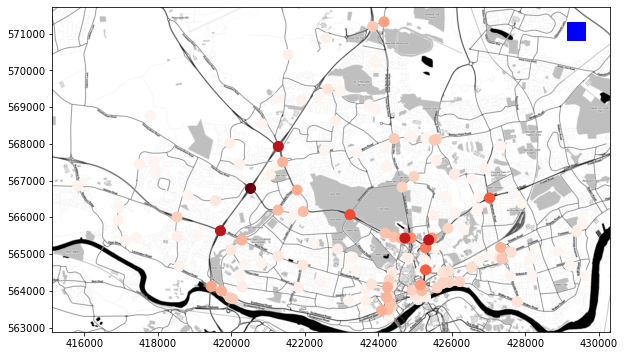

In [83]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
gdf["sqrt_traffic"] = np.sqrt(gdf["traffic_co"])
gdf.sort_values(by="sqrt_traffic").plot(
    ax=ax,
    column="traffic_co",
    markersize=100,
    cmap="Reds"
)

ctx.add_basemap(
    ax,
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=gdf.crs.to_epsg()
)

x = gdf["geometry"].x
y = gdf["geometry"].y

# add square for scale comparison
size = 500
bot_left = (x.max()-size, y.max()-size) 
ax.add_patch(
    patches.Rectangle(bot_left, size, size, color="b")
)

ax.get_xlim()

In [96]:
from spineq.utils import distance_matrix

d = distance_matrix(x, y)

import numpy as np
d[np.triu_indices_from(d, k=1)].min()

14.560219777849442

count      152.000000
mean      1704.177632
std       2436.962043
min          6.000000
25%         88.500000
50%        527.000000
75%       2605.000000
max      13357.000000
Name: traffic_co, dtype: float64

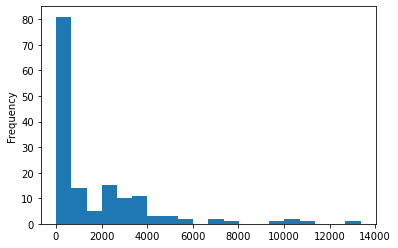

In [27]:
gdf.traffic_co.plot.hist(bins=20)

gdf.traffic_co.describe()

## calc weights

In [124]:
from spineq.data_fetcher import get_oa_stats, get_traffic_counts

In [197]:
import pandas as pd

def calc_oa_weights(
    population_weight=1,
    workplace_weight=0,
    pop_age_groups={
        "pop_total": {"min": 0, "max": 90, "weight": 1},
        "pop_children": {"min": 0, "max": 16, "weight": 0},
        "pop_elderly": {"min": 70, "max": 90, "weight": 0},
    },
    traffic_weight=0,
    combine=True,
):
    """Calculate weighting factor for each OA.
    
    Keyword Arguments:        
        population_weight {float} -- Weighting for residential population
        (default: {1})
        
        workplace_weight {float} -- Weighting for workplace population
        (default: {0})
        
        pop_age_groups {dict} -- Residential population age groups to create
        objectives for and their corresponding weights. Dict with objective
        name as key. Each entry should be another dict with keys min (min age
        in population group), max (max age in group), and weight (objective
        weight for this group).
        
        combine {bool} -- If True combine all the objectives weights into a
        single overall weight using the defined weighting factors. If False
        treat all objectives separately, in which case all weights defined in
        other parameters are ignored.
    
    Returns:
        pd.DataFrame or pd.Series -- Weight for each OA (indexed by oa11cd) for
        each objective. Series if only one objective defined or combine is True.
    """

    data = get_oa_stats()
    population_ages = data["population_ages"]
    workplace = data["workplace"]

    all_weights = None
    
    if len(population_ages) != len(workplace):
        raise ValueError(
            "Lengths of inputs don't match: population_ages={}, workplace={}".format(
                len(population_ages), len(workplace)
            )
        )

    # weightings for residential population by age group
    if population_weight > 0:
        oa_population_group_weights = {}
        for name, group in pop_age_groups.items():
            # skip calculation for zeroed objectives
            if group["weight"] == 0:
                continue

            # get sum of population in group age range
            group_population = population_ages.loc[
                :,
                (population_ages.columns >= group["min"])
                & (population_ages.columns <= group["max"]),
            ].sum(axis=1)

            # normalise total population
            group_population = group_population / group_population.sum()

            # if objectives will be combined, scale by group weight
            if combine:
                group_population = group_population * group["weight"]

            oa_population_group_weights[name] = group_population

        if len(oa_population_group_weights) > 0:
            use_population = True  # some population groups with non-zero weights

            oa_population_group_weights = pd.DataFrame(oa_population_group_weights)
            if combine:
                oa_population_group_weights = oa_population_group_weights.sum(axis=1)
                oa_population_group_weights = population_weight * (
                    oa_population_group_weights / oa_population_group_weights.sum()
                )
                oa_population_group_weights.name = "population"
                
            if all_weights is None:
                all_weights = pd.DataFrame(oa_population_group_weights)
            else:
                all_weights = pd.DataFrame(all_weights).join(oa_population_group_weights, how="outer")
        else:
            use_population = False  #  all population groups had zero weight
    else:
        use_population = False

    # weightings for number of workers in OA (normalised to sum to 1)
    if workplace_weight > 0:
        use_workplace = True
        workplace = workplace / workplace.sum()
        if combine:
            workplace = workplace_weight * workplace
        workplace.name = "workplace"
        
        if all_weights is None:
            all_weights = workplace
        else:
            all_weights = pd.DataFrame(all_weights).join(workplace, how="outer")
    else:
        use_workplace = False

    # weightings for traffic intersections
    if traffic_weight > 0:
        use_traffic = True
        traffic = get_traffic_counts()["traffic_co"]
        traffic = traffic_counts / traffic_counts.sum()
        traffic.name = "traffic"
        if combine:
            traffic = traffic_weight * traffic
            
        if all_weights is None:
            all_weights = traffic
        else:
            all_weights = pd.DataFrame(all_weights).join(traffic, how="outer")
    else:
        use_traffic = False
            
    if not use_population and not use_workplace and not use_traffic:
        raise ValueError("Must specify at least one non-zero weight.")

   
    all_weights = all_weights.fillna(0)
    
    if len(all_weights.columns) == 1:
        return all_weights[all_weights.columns[0]]
    elif combine:
        all_weights = all_weights.sum(axis=1)
        return all_weights / all_weights.sum()
    else:
        return all_weights

In [201]:
calc_oa_weights(
    population_weight=1,
    workplace_weight=0,
    pop_age_groups={
        "pop_total": {"min": 0, "max": 90, "weight": 1},
        "pop_children": {"min": 0, "max": 16, "weight": 1},
        "pop_elderly": {"min": 70, "max": 90, "weight": 0},
    },
    traffic_weight=0,
    combine=False,
)

oa11cd
E00042044    0.000785
E00042052    0.000996
E00042054    0.000989
E00042055    0.001056
E00042058    0.000453
               ...   
E00042600    0.002684
E00042873    0.001264
E00042877    0.002541
E00042900    0.002215
E00042901    0.001848
Name: pop_total, Length: 952, dtype: float64

In [163]:
traffic_counts = get_traffic_counts()["traffic_co"]
traffic_weight = traffic_counts / traffic_counts.sum()
traffic_weight.name = "traffic"

In [164]:
oa_weight = calc_oa_weights(workplace_weight=1, combine=False)
oa_weight

,pop_total,workplace
oa11cd,,
E00042044,0.000785,0.000260
E00042052,0.000996,0.000145
E00042054,0.000989,0.000115
E00042055,0.001056,0.000943
E00042058,0.000453,0.000151
...,...,...
E00042600,0.002684,0.001813
E00042873,0.001264,0.001076
E00042877,0.002541,0.000284


In [165]:
all_weight = oa_weight.join(traffic_weight, how="outer").fillna(0)
all_weight

,pop_total,workplace,traffic
0,0.000000,0.000000,0.010062
1,0.000000,0.000000,0.010062
2,0.000000,0.000000,0.006416
3,0.000000,0.000000,0.014705
4,0.000000,0.000000,0.011986
...,...,...,...
E00175601,0.000447,0.000030,0.000000
E00175602,0.000766,0.000048,0.000000
E00175603,0.000919,0.000199,0.000000
E00175604,0.000782,0.000006,0.000000


In [ ]:
oa_weight["poi_type"] = "oa"

traffic_weight = pd.DataFrame(traffic_weight)
traffic_weight["poi_type"] = "intn"

In [167]:
all_weight["poi_type"] = np.nan
all_weight.loc[all_weight.index.isin(oa_weight.index), "poi_type"] = "output_area"
all_weight.loc[all_weight.index.isin(traffic_weight.index), "poi_type"] = "intersection"

all_weight

,pop_total,workplace,traffic,poi_type
0,0.000000,0.000000,0.010062,intersection
1,0.000000,0.000000,0.010062,intersection
2,0.000000,0.000000,0.006416,intersection
3,0.000000,0.000000,0.014705,intersection
4,0.000000,0.000000,0.011986,intersection
...,...,...,...,...
E00175601,0.000447,0.000030,0.000000,output_area
E00175602,0.000766,0.000048,0.000000,output_area
E00175603,0.000919,0.000199,0.000000,output_area
E00175604,0.000782,0.000006,0.000000,output_area
